In [1]:
import tensorflow as tf
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from dataGenerator import make_generator, small_dset_gen

In [2]:
def station_conv(mag_input):
    """extracts features from the magnetic field information
    
    mag_input: 4D Tensor - batch (1) x stations (?) x time (128) x component (3)
    """
    # conv - conv - pool
    c1_kernel = tf.get_variable("C1_kernel", shape=[1,5,3,32], dtype=tf.float32, trainable=True)
    C1 = tf.nn.conv2d(mag_input, c1_kernel, strides=[1,1,1,1], padding="SAME")
    A1 = tf.nn.leaky_relu(C1)
    
    c2_kernel = tf.get_variable("C2_kernel", shape=[1,3,32,32], dtype=tf.float32, trainable=True)
    C2 = tf.nn.conv2d(A1, c2_kernel, strides=[1,1,1,1], padding="SAME")
    A2 = tf.nn.leaky_relu(C2)
    
    P1 = tf.nn.max_pool(A2, ksize=[1,1,2,1], strides=[1,1,2,1], padding="SAME")
    # batch x stations x 64 x 32
    
    # conv - conv - pool
    c3_kernel = tf.get_variable("C3_kernel", shape=[1,3,32,64], dtype=tf.float32, trainable=True)
    C3 = tf.nn.conv2d(P1, c3_kernel, strides=[1,1,1,1], padding="SAME")
    A3 = tf.nn.leaky_relu(C3)
    
    c4_kernel = tf.get_variable("C4_kernel", shape=[1,3,64,64], dtype=tf.float32, trainable=True)
    C4 = tf.nn.conv2d(A3, c4_kernel, strides=[1,1,1,1], padding="SAME")
    A4 = tf.nn.leaky_relu(C4)
    
    P2 = tf.nn.max_pool(A4, ksize=[1,1,2,1], strides=[1,1,2,1], padding="SAME")
    # batch x stations x 32 x 64
    
    # conv - pool
    c5_kernel = tf.get_variable("C5_kernel", shape=[1,3,64,64], dtype=tf.float32, trainable=True)
    C5 = tf.nn.conv2d(P2, c5_kernel, strides=[1,1,1,1], padding="SAME")
    A5 = tf.nn.leaky_relu(C5)    
    mag_features = tf.nn.max_pool(A5, ksize=[1,1,2,1], strides=[1,1,2,1], padding="SAME")
    # batch x station x 16 x 64
    
    return mag_features


In [3]:
def station_net(mag_features, st_loc):
    """aggregates information from magnetic field data and positions
    
    mag_features: batch x stations x 16 x 64
    st_loc: stations x 3
    """
    
    # reshape and concatenate
    mag_sh = tf.shape(mag_features)
    station_vectors = tf.reshape(mag_features, [mag_sh[0], mag_sh[1], 1024])
    station_vectors = tf.concat([station_vectors, st_loc], axis=2)
    # batch x stations x 1027
    
    # FC net
    W1 = tf.get_variable("st_net_w1", shape=[1027, 1024], dtype=tf.float32, trainable=True)
    b1 = tf.get_variable("st_net_b1", shape=[1024], dtype=tf.float32, trainable=True)
    D1 = tf.reduce_sum(station_vectors[:,:,:,None] * W1[None,None,:,:], axis=2) + b1
    A1 = tf.nn.leaky_relu(D1)
    # batch x stations x 1024
    
    W2 = tf.get_variable("st_net_w2", shape=[1024, 1024], dtype=tf.float32, trainable=True)
    b2 = tf.get_variable("st_net_b2", shape=[1024], dtype=tf.float32, trainable=True)
    D2 = tf.reduce_sum(A1[:,:,:,None] * W2[None,None,:,:], axis=2) + b2
    st_features = tf.nn.leaky_relu(D2)
    # batch x stations x 1024
    
    return st_features


In [4]:
def global_conv(global_params):
    """extracts features from the global parameters (solar wind, etc.)
    """
    global_features = None
    return global_features


In [5]:
def aggregator(st_features, global_features):
    """adds up the station vectors, concatenates with the global features,
    outputs the substorm prediction
    
    st_features: 3D tensor - batch x stations x features
    """
    
    station_sum = tf.reduce_mean(st_features, axis=1)
    # batch x features
    
    # FC net
    D1 = tf.layers.dense(station_sum, 1024, trainable=True)
    A1 = tf.nn.leaky_relu(D1)
    D2 = tf.layers.dense(A1, 1024, trainable=True)
    A2 = tf.nn.leaky_relu(D2)
    model_output = tf.layers.dense(A2, 5, trainable=True) # yes/no, time, MLAT, sinMLT, cosMLT
    
    return model_output


In [6]:
def loss_function(model_output, ss_occurred, ss_time, ss_loc):
    """calculates loss based on model output and the substorm occurance
    
    model_output = batch x (ss_occurred, time, MLAT, sinMLT, cosMLT)
    """
    
    occurance_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=ss_occurred[:,0], logits=model_output[:,0])
    time_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=ss_time[:,0], logits=model_output[:,1])
    location_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=ss_loc, logits=model_output[:,2:])
    
    loss = tf.reduce_mean(occurance_loss)# + 0 * ss_occurred * (time_loss + location_loss))
    
    return loss

1 62.76091629266739 2.0813953488372094
2 61.06328630447388 1.941860465116279
3 60.42761170864105 1.994186046511628
4 60.064006209373474 2.2093023255813953
5 59.96165233850479 2.2209302325581395
6 59.84668028354645 2.2209302325581395
7 59.7408863902092 2.2209302325581395
8 59.68088412284851 2.2209302325581395
9 59.675053894519806 2.2209302325581395
10 59.707183480262756 2.2209302325581395
11 59.7002038359642 2.2209302325581395
12 59.682409822940826 2.2209302325581395
13 59.586435198783875 2.2209302325581395
14 59.53928995132446 2.2209302325581395
15 59.54145169258118 2.2209302325581395
16 59.55191111564636 2.2209302325581395
17 59.55754780769348 2.2209302325581395
18 59.575443625450134 2.2209302325581395
19 59.91266465187073 2.11046511627907
20 60.0339817404747 2.11046511627907


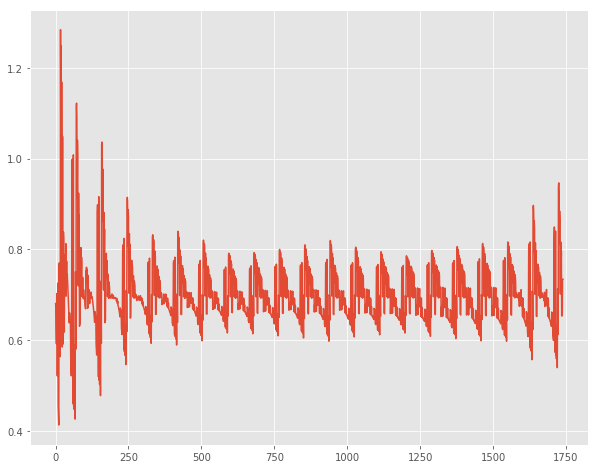

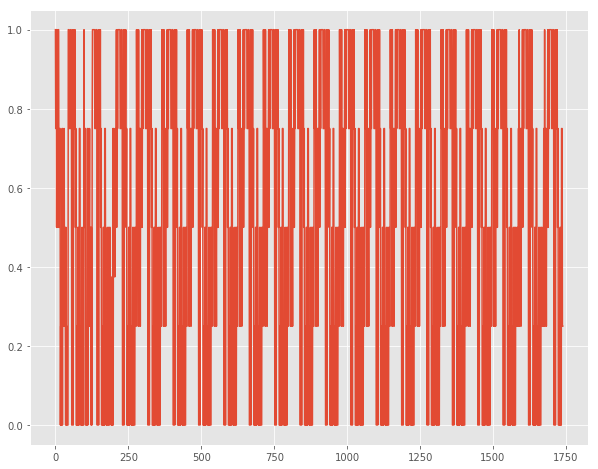

In [7]:
tf.reset_default_graph()

BATCHSIZE = 4
EPOCHS = 20

os.chdir("C://Users//Greg//code//space physics//experiment//data")

mag_files = glob.glob("mag_data*.nc")
ss_file = ss_file = "substorms_2000_2018.csv"
stats_file = "statistics.npz"
data_interval = 127 # choose something that can be divided by two 4-5 times
prediction_interval = 150

gen = small_dset_gen(mag_files[0], ss_file, stats_file, data_interval, prediction_interval)

dataset = tf.data.Dataset.from_generator(gen,
                                         output_types = (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32),
                                         output_shapes = (tf.TensorShape([None, data_interval+1, 3]),
                                                          tf.TensorShape([None, 3]),
                                                          tf.TensorShape([1]),
                                                          tf.TensorShape([1]),
                                                          tf.TensorShape([3]))
                                        )
dataset = dataset.padded_batch(BATCHSIZE,
                               (tf.TensorShape([None,None,None]), 
                                tf.TensorShape([None,None]), 
                                tf.TensorShape([None]), 
                                tf.TensorShape([None]),
                                tf.TensorShape([None])))
dataset = dataset.prefetch(1)

data_iter = dataset.make_initializable_iterator()
with tf.device("/cpu:0"):
    mag_input, st_loc, ss_occurred, ss_time, ss_loc = data_iter.get_next()
global_params = None

mag_features = station_conv(mag_input)
st_features = station_net(mag_features, st_loc)
global_features = global_conv(global_params)
model_output = aggregator(st_features, global_features)

loss = loss_function(model_output, ss_occurred, ss_time, ss_loc)
confidence = tf.nn.sigmoid(model_output[:,0])

opt = tf.train.AdamOptimizer(learning_rate=5.0e-5)
train_step = opt.minimize(loss)
grads = opt.compute_gradients(loss)

accuracy_hist = []
loss_hist = []
stfs = []
epochs = 0

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
with tf.device("/device:GPU:0"):
    sess.run(tf.global_variables_initializer())
    sess.run(data_iter.initializer)
    epoch_loss = 0
    epoch_right = 0
    epoch_total = 0
    while epochs < EPOCHS:
        try:
            _, l, con, mi, occ, mf, sf = sess.run([train_step, loss, confidence, mag_input, ss_occurred, mag_features, st_features])
            epoch_loss += l
            epoch_right += np.sum(np.round(con)==occ)
            epoch_total += BATCHSIZE
        except tf.errors.OutOfRangeError:
            epochs += 1
            print(epochs, epoch_loss, epoch_right/epoch_total)
            sess.run(data_iter.initializer)
            epoch_loss = 0
            epoch_right = 0
            epoch_total = 0
        loss_hist.append(l)
        acc = np.mean(np.round(con) == occ)
        accuracy_hist.append(acc)
        
plt.figure(figsize=(10,8))
plt.plot(loss_hist)
plt.figure(figsize=(10,8))
plt.plot(accuracy_hist)

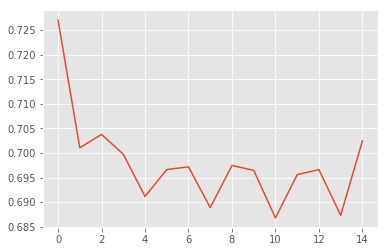

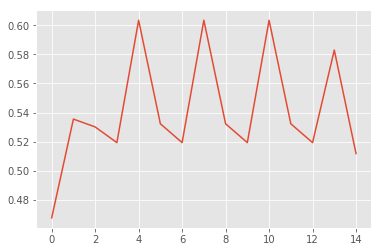

In [15]:
plt.figure()
plt.plot(np.mean(np.array(loss_hist)[np.arange(len(loss_hist)).reshape((-1,116))], axis=1))
plt.figure()
plt.plot(np.mean(np.array(accuracy_hist)[np.arange(len(accuracy_hist)).reshape((-1,116))], axis=1))

0.0


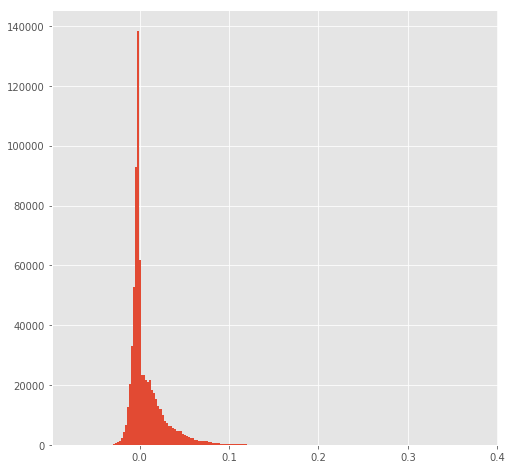

In [9]:
plt.figure(figsize=(8,8))
b = plt.hist(mf.ravel(),200)
print(np.sum(sf==0)/np.prod(sf.shape))